In [201]:
import pandas as pd
import numpy as np

In [202]:
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams

In [203]:
from greykite.common.data_loader import DataLoader
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.algo.forecast.silverkite.constants.silverkite_holiday import SilverkiteHoliday

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

from scipy import stats
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox

In [205]:
%matplotlib inline

Мы хотим предсказать DAU — ежедневную аудиторию сервиса — на основании исторических данных, которые у нас имеются

DAU — это очень важная для бизнеса величина. Она позволяет понимать следующее:
    - сколько у бизнеса активной аудитории ежедневно
    - сколько бизнес может зарабатывать в день, с учетом конверсии в покупку/другое целевое действие
    - сколько бизнесу нужно закупать рекламы в различных платных каналах для поддержания/увеличения аудитории 
    - как влияют различные рекламные кампании на сервис, сколько пользователей приходит из каналов

Загрузим данные о пользователях сервиса из файла

In [211]:
original_df = pd.read_csv("tms.csv")
original_df_prophet = pd.read_csv("tms.csv")

In [212]:
original_df.head()

,day,users
0,01/02/21,11
1,02/02/21,8
2,03/02/21,10
3,04/02/21,10
4,05/02/21,7


Преобразуем формат даты в более удобный для нас, из строкового в датовый

In [213]:
from datetime import datetime

for i in range(original_df['day'].shape[0]):
    original_df['day'][i] = '20'+ original_df['day'][i][6:] + '-' + original_df['day'][i][3:5] + '-' + original_df['day'][i][:2]
    original_df['day'][i] = datetime.strptime(original_df['day'][i], '%Y-%m-%d').date()

In [214]:
original_df.head()

,day,users
0,2021-02-01,11
1,2021-02-02,8
2,2021-02-03,10
3,2021-02-04,10
4,2021-02-05,7


Теперь посмотрим визуализацию временного ряда, чтобы выявить важные признаки ряда:

- Тренд – это долговременная тенденция изменения исследуемого временного ряда. 

- Сезонность – это периодически колебания, наблюдаемые на временных рядах. Сезонность может быть недельной, месячной, квартальной и тд.

- Дисперсия ряда — это разброс значений ряда.

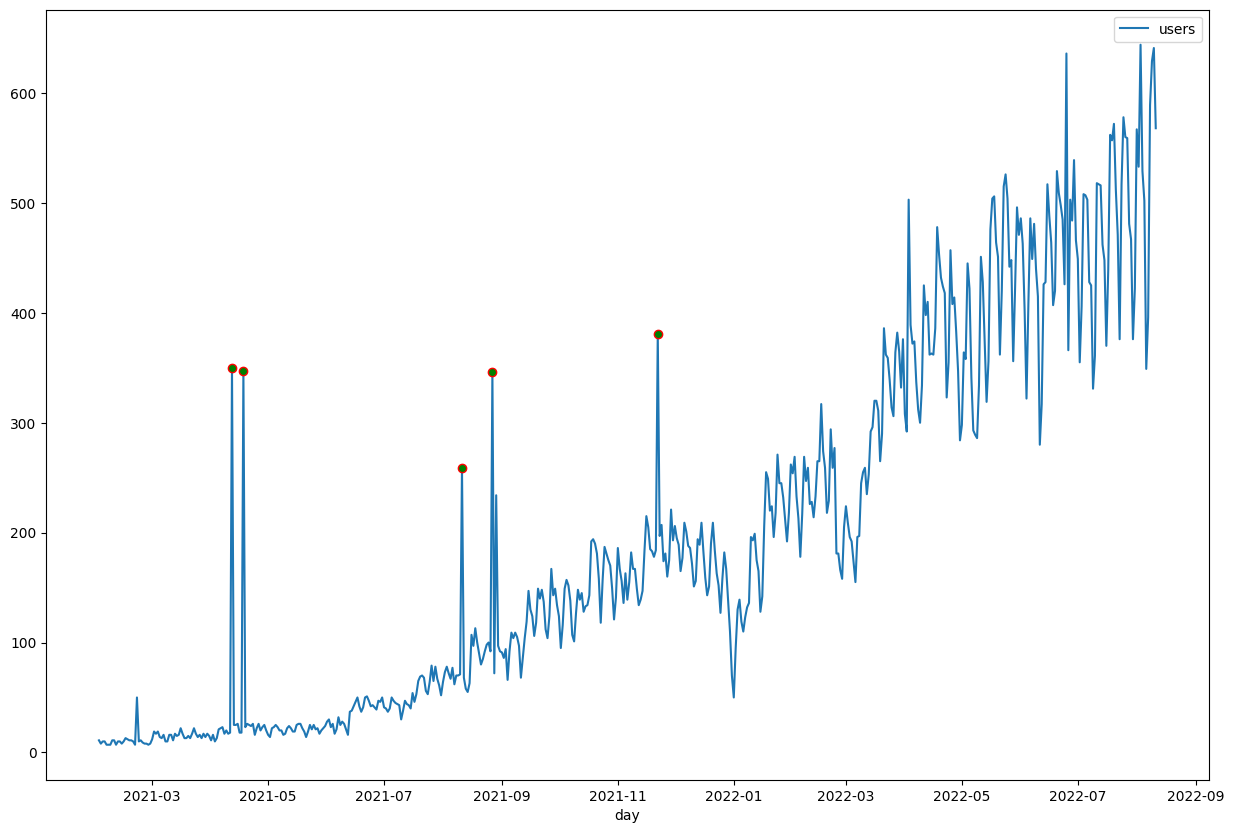

In [215]:
x1=original_df[original_df.day==datetime.strptime("2021-04-12", '%Y-%m-%d').date()].users.values[0]
y1= datetime.strptime("2021-04-12", '%Y-%m-%d').date()

x2=original_df[original_df.day==datetime.strptime("2021-04-18", '%Y-%m-%d').date()].users.values[0]
y2= datetime.strptime("2021-04-18", '%Y-%m-%d').date()

x3=original_df[original_df.day==datetime.strptime("2021-08-11", '%Y-%m-%d').date()].users.values[0]
y3= datetime.strptime("2021-08-11", '%Y-%m-%d').date()

x4=original_df[original_df.day==datetime.strptime("2021-08-27", '%Y-%m-%d').date()].users.values[0]
y4= datetime.strptime("2021-08-27", '%Y-%m-%d').date()

x5=original_df[original_df.day==datetime.strptime("2021-11-22", '%Y-%m-%d').date()].users.values[0]
y5= datetime.strptime("2021-11-22", '%Y-%m-%d').date()

original_df.plot( x='day' , y='users' ,figsize=(15, 10))
plt.plot(y1,x1,  marker="o", markeredgecolor="red", markerfacecolor="green")
plt.plot(y2,x2,  marker="o", markeredgecolor="red", markerfacecolor="green")
plt.plot(y3,x3,  marker="o", markeredgecolor="red", markerfacecolor="green")
plt.plot(y4,x4,  marker="o", markeredgecolor="red", markerfacecolor="green")
plt.plot(y5,x5,  marker="o", markeredgecolor="red", markerfacecolor="green")

Видим, что у временного ряда есть сильный тренд, практически линейный. С течением времени количество пользователей сервиса растет, поэтому тренд здесь восходящий.

Также наблюдаем несколько выбросов – измерений, выделяющихся из общей выборки – в течение 2021 года, которые могут влиять на разброс значений. Их мы визуально отметили зелеными точками.

Дисперсия ряда в начале ряда была низкой, под конец временного периода стала больше.

Также видно, что в ряде может присутствовать сезонность – какая она именно увидим дальше.

Проверим, что пропусков дней в данных нет. Иначе нам нужно заполнять их данными, например, типа среднего значения:

In [216]:
pd.date_range(start = '2021-02-01', end = '2022-08-11' ).difference(original_df.day)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Теперь начнем преобразование исходного датасета в формат для работы с библиотекой Greykite от LinkedInn

In [217]:
original_df['ds'] = original_df['day']
original_df.rename(columns={'users': 'y'}, inplace=True)

#set index as time for the series
original_df = original_df.set_index('day')

In [218]:
original_df.head()

,y,ds
day,,
2021-02-01,11,2021-02-01
2021-02-02,8,2021-02-02
2021-02-03,10,2021-02-03
2021-02-04,10,2021-02-04
2021-02-05,7,2021-02-05


Построим автокорреляционную функцию для ряда, чтобы сделать предположение о сезонности:

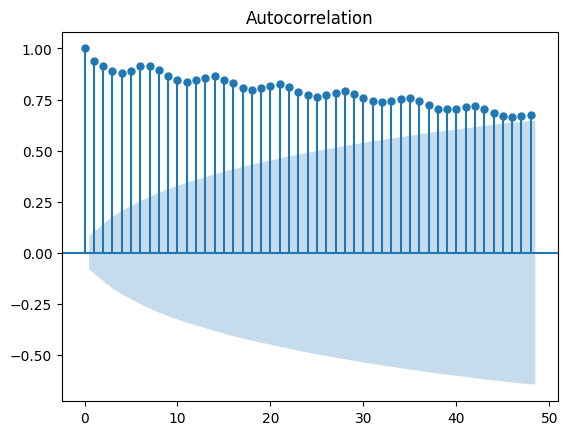

In [219]:
sm.graphics.tsa.plot_acf(original_df.y, lags=48);

Видим явные пики в графике, соответствующие неделям – на 7, 14, 21 и тд лагах. Поэтому делаем вывод, что у ряда наблюдается недельная сезонность

Если декомпозировать временной ряд на составляющие, получим те же выводы, что и из визуального анализа ряда – есть сезонность и есть тренд, дисперсия увеличивается со временем:

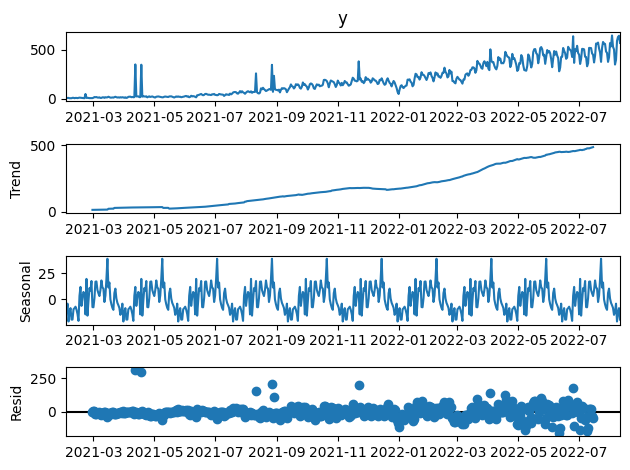

In [220]:
sm.tsa.seasonal_decompose(original_df.y, period=55).plot()
plt.show()

Посмотрим на коэффициенты корреляции значений ряда с лагами — недельным, месячным, годовым. 

Лаги — это некоторое предыдущее значение временного ряда. Например, первый лаг — это вчерашнее значение. А пятый лаг — значение пять дней назад. 

Коэффициент корреляции позволяет увидеть, есть ли между данными ряда и лагами зависимость.

In [221]:
original_df['lag_7']= original_df.y.shift(7)
original_df['lag_30']= original_df.y.shift(30)
original_df['lag_365']= original_df.y.shift(365)

In [222]:
original_df.corr()

,y,lag_7,lag_30,lag_365
y,1.000000,0.950575,0.893700,0.418349
lag_7,0.950575,1.000000,0.893144,0.379871
lag_30,0.893700,0.893144,1.000000,0.325259
lag_365,0.418349,0.379871,0.325259,1.000000


Значение коэф. корреляции высокое у лага 7 и 30, а значит, у ряда есть недельная и месячная сезонность. Годовой сезонности нет

# Наивное предсказание c помощью модели SilverKite библиотеки GreyKite

Попробуем предсказать будущие 30 дней ряда

Обучим модель, никак не преобразовывая данные ряда и не учитывая его сезонность с трендом. После посмотрим на ее качество

In [223]:
metadata = MetadataParam(
    time_col="ds",     
    value_col="y",      
    freq="D"           
)

forecaster = Forecaster()  # creates forecasts and stores the result

result = forecaster.run_forecast_config(
     df=original_df,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=30,  
         coverage=0.95,        # 95% prediction intervals
         metadata_param=metadata
     )
 )

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Метод run_forecast_config возвращает сам временной ряд, предсказание будущих значений для заданного forecast_horizon, а также предсказание прошлых значений ряда (кросс валидацию и бэктест)

Кросс валидация — это метод оценки аналитической модели и её поведения на независимых данных с наиболее равномерным использованием имеющихся данных.

1. В основе метода лежит разделение исходного множества данных на k примерно равных блоков, например k=5. 

2. Затем на k−1 (на 4-х блоках) производится обучение модели, а 5-й блок используется для тестирования.

3. Процедура повторяется k раз, при этом на каждом проходе для проверки выбирается новый блок, а обучение производится на оставшихся.

Посмотрим на результаты кросс валидации, которые хранятся в .grid_search. Автоматически определилось оптимальное количество фолдов - 3 (так как данных у нас достаточно мало). 

Для каждого сплита мы посчитаем метрику MAPE – mean absolute percentage error – и выведем ее. Эта метрика показывает средний абсолютный процент ошибок и очень удобна, когда мы хотим объяснить бизнесу, насколько модель ошибается

In [224]:
grid_search = result.grid_search

cv_results = summarize_grid_search_results(
     grid_search=grid_search,
     decimals=2,
     cv_report_metrics=None,
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,35.59
split_test_MAPE,"(84.55, 11.1, 11.13)"
mean_train_MAPE,49.62
split_train_MAPE,"(67.38, 38.85, 42.63)"
mean_fit_time,3.13
mean_score_time,0.76


Посмотрим на график бэктеста. При бэктесте мы выбираем период времени в прошлом, строим модель, используя выбранный интервал в качестве обучающей выборки, а потом прогнозируем значение на захолдированном тестовом интервале (он холдируется с конца временного ряда) и вычисляем метрики. 

In [225]:
backtest = result.backtest
fig = backtest.plot()
plotly.io.show(fig)

В результатах бэктеста видно, что модель уловила тренд и сезонность, но фактические значения имели бОльший разброс, чем предсказание

Посмотрим на результаты предсказания

In [226]:
forecast = result.forecast
forecast.plot()

Видно, что для будущих значений даты модель уловила восходящий тренд и сезонность, визуально предсказание похоже на то, как будет выглядеть аудитория сервиса в будущем месяце

# Предсказание с предварительным преобразованием данных и учетом компонент ряда

Проведем преобразование Бокса-Кокса, чтобы стабилизировать дисперсию значений ряда

In [227]:
original_df['y'], lbmd = stats.boxcox(original_df['y'])

In [228]:
original_df.head()

,y,ds,lag_7,lag_30,lag_365
day,,,,,
2021-02-01,3.408661,2021-02-01,NaN,NaN,NaN
2021-02-02,2.815119,2021-02-02,NaN,NaN,NaN
2021-02-03,3.225478,2021-02-03,NaN,NaN,NaN
2021-02-04,3.225478,2021-02-04,NaN,NaN,NaN
2021-02-05,2.581457,2021-02-05,NaN,NaN,NaN


После преобразования Бокса-Кокса дисперсия ряда стала более стабильной, в конце ряда у нас уже нет таких разбросов, как в изначальном ряду до преобразования:

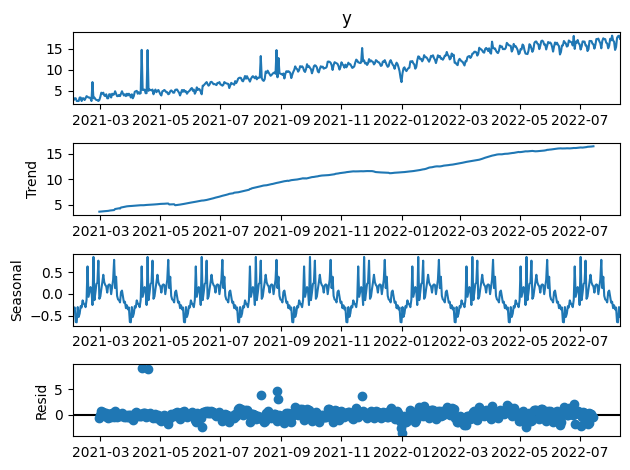

In [229]:
sm.tsa.seasonal_decompose(original_df.y, period=55).plot()
plt.show()

Теперь также учтем такие компоненты для модели, как тренд, сезонность, наличие праздников в определенный день. Мы положим их в ModelComponentsParam, который потом укажем в run_forecast_config

Попробуем перебрать параметры модели и определить лучшие. Переберем разные значения для тренда, месячной и недельной сезонности

In [230]:
growth = dict(growth_term=["linear", "quadratic"]) 

In [231]:
seasonality = dict(
    yearly_seasonality=False,
    quarterly_seasonality=False,
    monthly_seasonality=[True, False, 30], 
    weekly_seasonality=[True, False, 7],
    daily_seasonality=False,
)

Учтем праздники:

In [232]:
events = {
     "holidays_to_model_separately": SilverkiteHoliday.ALL_HOLIDAYS_IN_COUNTRIES,  
     "holiday_lookup_countries": ["Russia"], 
     "holiday_pre_num_days": 2, 
     "holiday_post_num_days": 2,  
}

Соберем все вместе:

In [233]:
model_components_ = ModelComponentsParam(
     seasonality=seasonality,
     growth=growth,
     events=events
)

In [234]:
metadata_ = MetadataParam(
    time_col="ds",     
    value_col="y",      
    freq="D"           
)

forecaster_ = Forecaster()  # creates forecasts and stores the result

result_ = forecaster_.run_forecast_config(
     df=original_df,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=30,  
         coverage=0.95,        # 95% prediction intervals
         metadata_param=metadata_,
         model_components_param=model_components_
     )
 )

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [235]:
forecast_ = result_.forecast

В forecast_.df хранятся данные предсказания в виде датафрейма:

In [236]:
forecast_.df.head() 

,ds,actual,forecast,forecast_lower,forecast_upper
0,2021-02-01,3.408661,4.678183,2.200628,7.155739
1,2021-02-02,2.815119,4.395356,2.997474,5.793238
2,2021-02-03,3.225478,4.615266,2.653091,6.577442
3,2021-02-04,3.225478,4.017816,2.519371,5.516260
4,2021-02-05,2.581457,3.818825,1.905298,5.732353


Не забудем об обратном преобразовании Бокса-Кокса:

In [237]:
forecast_.df['forecast'] = inv_boxcox(forecast_.df['forecast'],lbmd)
forecast_.df['actual'] = inv_boxcox(forecast_.df['actual'],lbmd)
forecast_.df['forecast_lower'] = inv_boxcox(forecast_.df['forecast_lower'],lbmd)
forecast_.df['forecast_upper'] = inv_boxcox(forecast_.df['forecast_upper'],lbmd)

Посмотрим на результаты кросс валидации

In [238]:
grid_search_ = result_.grid_search
cv_results_ = summarize_grid_search_results(
     grid_search=grid_search_,
     decimals=2,
     cv_report_metrics=None,
     column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])

cv_results_["params"] = cv_results_["params"].astype(str)
cv_results_.set_index("params", drop=True, inplace=True)
cv_results_.transpose()

params,"[('estimator__weekly_seasonality', True), ('estimator__monthly_seasonality', True), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', False), ('estimator__monthly_seasonality', True), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', 7), ('estimator__monthly_seasonality', True), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', True), ('estimator__monthly_seasonality', False), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', False), ('estimator__monthly_seasonality', False), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', 7), ('estimator__monthly_seasonality', False), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', True), ('estimator__monthly_seasonality', 30), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', False), ('estimator__monthly_seasonality', 30), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', 7), ('estimator__monthly_seasonality', 30), ('estimator__growth_term', 'linear')]","[('estimator__weekly_seasonality', True), ('estimator__monthly_seasonality', True), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', False), ('estimator__monthly_seasonality', True), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', 7), ('estimator__monthly_seasonality', True), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', True), ('estimator__monthly_seasonality', False), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', False), ('estimator__monthly_seasonality', False), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', 7), ('estimator__monthly_seasonality', False), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', True), ('estimator__monthly_seasonality', 30), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', False), ('estimator__monthly_seasonality', 30), ('estimator__growth_term', 'quadratic')]","[('estimator__weekly_seasonality', 7), ('estimator__monthly_seasonality', 30), ('estimator__growth_term', 'quadratic')]"
rank_test_MAPE,10,8,11,12,9,13,4,3,1,15,14,7,17,16,18,6,5,2
mean_test_MAPE,11.95,11.41,12.01,12.29,11.91,12.34,7.29,7.16,5.93,15.71,15.06,10.96,16.23,15.95,16.29,9.44,8.96,6.84
split_test_MAPE,"(28.48, 2.0, 5.39)","(26.84, 2.06, 5.33)","(28.65, 2.0, 5.38)","(29.33, 2.05, 5.48)","(27.9, 2.09, 5.75)","(29.47, 2.05, 5.48)","(14.07, 2.29, 5.52)","(13.08, 2.37, 6.03)","(9.97, 2.3, 5.51)","(38.59, 3.56, 4.97)","(36.71, 3.54, 4.94)","(24.36, 3.57, 4.97)","(40.14, 3.45, 5.1)","(38.31, 4.48, 5.07)","(40.3, 3.46, 5.1)","(19.37, 3.91, 5.03)","(18.03, 3.86, 4.99)","(11.56, 3.94, 5.03)"
mean_train_MAPE,10.57,10.36,10.61,10.62,10.3,10.67,9.92,9.76,10.8,11.92,11.72,12.3,12.0,11.69,12.06,10.71,10.75,11.55
split_train_MAPE,"(15.91, 7.77, 8.02)","(15.23, 7.8, 8.04)","(16.04, 7.77, 8.03)","(15.96, 7.81, 8.1)","(15.43, 7.84, 7.64)","(16.09, 7.81, 8.11)","(13.88, 7.68, 8.19)","(13.88, 7.7, 7.72)","(16.5, 7.68, 8.21)","(16.11, 11.58, 8.06)","(15.54, 11.57, 8.07)","(17.23, 11.59, 8.07)","(16.18, 11.7, 8.12)","(15.8, 11.15, 8.12)","(16.36, 11.71, 8.13)","(13.77, 11.22, 7.14)","(13.89, 11.21, 7.15)","(16.3, 11.23, 7.14)"
mean_fit_time,2.44,2.5,2.52,2.43,2.3,2.72,2.91,2.78,3.02,2.4,2.22,2.39,2.29,2.18,2.32,2.88,2.81,3.15
mean_score_time,0.69,0.65,0.68,0.71,0.67,0.7,0.72,0.71,0.73,0.65,0.62,0.64,0.63,0.61,0.64,0.75,0.7,0.71


Получили целый список моделей со своими уникальными значениями параметров, которые мы инициализировали раньше. Для всех них была посчитана MAPE на всех трех фолдах кросс валидации

Ошибки на тесте и на трейне сильно уменьшились по сравнению с предыдущей моделью, в которой мы не учитывали компоненты ряда и не сделали преобразование Бокса-Кокса

Посмотрим на график бэктеста:

In [239]:
backtest_ = result_.backtest
fig = backtest_.plot()
plotly.io.show(fig)

В бэктесте видим, что модель сделала немного более оптимистичное предсказание по сравнению с реальными данными

Посмотрим на предсказание будущего:

In [240]:
forecast_ = result_.forecast
forecast_.plot()

Видно, что модель уловила восходящий тренд и сезонность, визуально предсказание похоже на то, как будет выглядеть аудитория сервиса в будущем месяце

# Наивное предсказание c помощью модели PROPHET библиотеки Kats

Теперь обучим популярную модель PROPHET, сначала тоже никак не преобразовывая данные ряда 

In [241]:
from datetime import datetime

for i in range(original_df_prophet['day'].shape[0]):
    original_df_prophet['day'][i] = '20'+ original_df_prophet['day'][i][6:] + '-' + original_df_prophet['day'][i][3:5] + '-' + original_df_prophet['day'][i][:2]
    original_df_prophet['day'][i] = datetime.strptime(original_df_prophet['day'][i], '%Y-%m-%d').date()

In [242]:
original_df_prophet.rename(columns={'day': 'time'}, inplace=True)
original_df_prophet.rename(columns={'users': 'value'}, inplace=True)

In [243]:
original_df_prophet.head()

,time,value
0,2021-02-01,11
1,2021-02-02,8
2,2021-02-03,10
3,2021-02-04,10
4,2021-02-05,7


In [244]:
ts = TimeSeriesData(original_df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<AxesSubplot:xlabel='time', ylabel='y'>

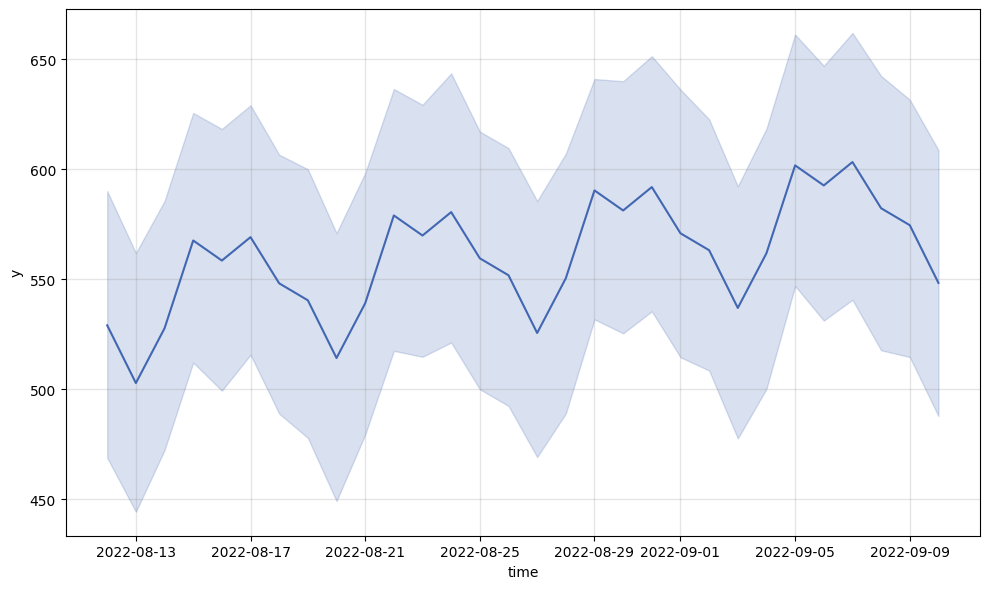

In [245]:
params = ProphetParams()

m = ProphetModel(ts, params)

m.fit()

fcst = m.predict(steps=30, freq="D")

m.plot()

Видим, что модель уловила тренд и сезонность. Но как будто недообучилась

# Предсказание с предварительным преобразованием данных и учетом компонент ряда

Сделаем преобразование Бокса-Кокса

In [246]:
original_df_prophet['value'], lbmd = stats.boxcox(original_df_prophet['value'])

In [247]:
original_df_prophet.head()

,time,value
0,2021-02-01,3.408661
1,2021-02-02,2.815119
2,2021-02-03,3.225478
3,2021-02-04,3.225478
4,2021-02-05,2.581457


In [248]:
ts_prophet = TimeSeriesData(original_df_prophet)

Учтем в модели тренд(линейный) и недельную сезонность и посмотрим на график:

<AxesSubplot:xlabel='time', ylabel='y'>

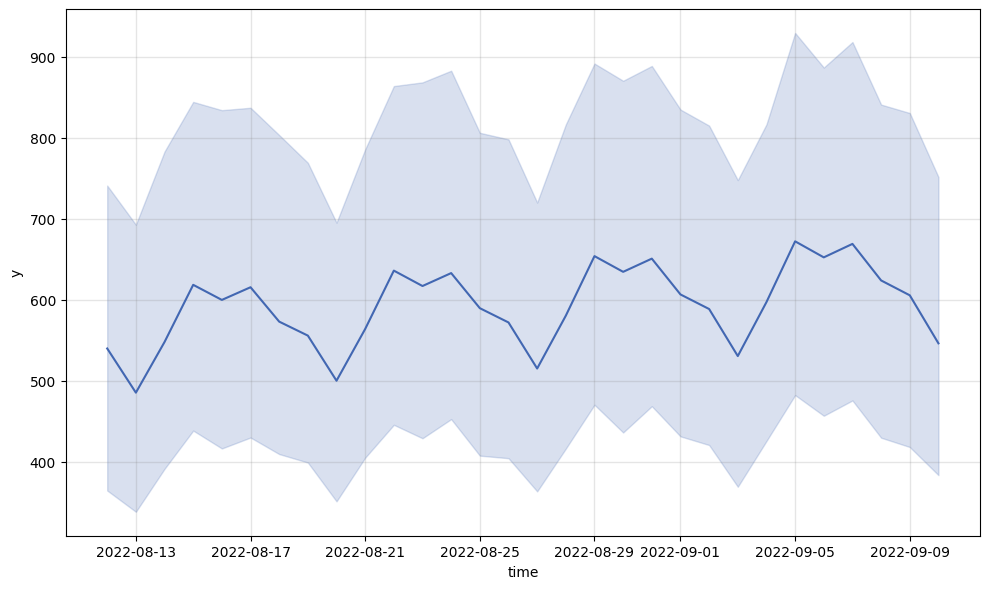

In [250]:
params = ProphetParams(growth='linear',yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False, interval_width=0.95)

m = ProphetModel(ts_prophet, params)

m.fit()

fcst = m.predict(steps=30,  freq="D")

fcst['fcst'] = inv_boxcox(fcst['fcst'],lbmd)
fcst['fcst_lower'] = inv_boxcox(fcst['fcst_lower'],lbmd)
fcst['fcst_upper'] = inv_boxcox(fcst['fcst_upper'],lbmd)

m.plot()

По сравнению с предыдущим графиком, это предсказание получилось более сглаженным. Дисперсия значения выше, чем на предыдущем графике

Теперь попробуем подобрать гиперпараметры для модели

Попробуем перебрать параметры модели и определить лучшие. Будем смотреть MAPE не на кросс валидации, как в SilverKite, а попробуем разделить выборку на обучающую и тестовую

In [251]:
parameters_grid_search = [
 {'name': 'seasonality_prior_scale',
  'type': 'choice',
  'value_type': 'float',
  'values': [0.01, 0.1, 1.0],
  'is_ordered': True},
 
 {'name': 'changepoint_prior_scale',
  'type': 'choice',
  'value_type': 'float',
  'values': [0.01, 0.1, 1.0],
  'is_ordered': True},
 
 {'name': 'changepoint_range',
  'type': 'choice',
  'value_type': 'float',
  'values': [0.8, 0.81, 0.82],
  'is_ordered': True}]

In [252]:
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType

In [253]:
parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name='MAPE',
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

C:\Users\Polina Lenovo\.conda\envs\newnew\lib\site-packages\ax\core\parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "seasonality_prior_scale". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\Polina Lenovo\.conda\envs\newnew\lib\site-packages\ax\core\parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "changepoint_prior_scale". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), specify `sort_values` during `ChoiceParameter` construction.

C:\Users\Polina Lenovo\.conda\envs\newnew\lib\site-packages\ax\core\parameter.py:468: UserWarning:

`sort_values` is not specified for `ChoiceParameter` "changepoint_range". Defaulting to `True` for parameters of `ParameterType` FLOAT. To override this behavior (or avoid this warning), spe

In [254]:
# Divide into an 80/20 training-test split
split = int(0.8*len(original_df_prophet))

train_ts = ts_prophet[0:split]
test_ts = ts_prophet[split:]

def evaluation_function(params):
    params = ProphetParams(
        seasonality_mode='multiplicative', 
        growth='linear',
        interval_width=0.95,
        daily_seasonality=False, 
        weekly_seasonality=True, 
        yearly_seasonality=False,
        seasonality_prior_scale = params['seasonality_prior_scale'],
        changepoint_prior_scale = params['changepoint_prior_scale'],
        changepoint_range = params['changepoint_range']
    )
    model = ProphetModel(train_ts, params)
    model.fit()
    model_pred = model.predict(steps=len(test_ts))
    
    t = inv_boxcox(test_ts.value,lbmd) # преобразуем обратно значения тестовой выборки
    pred_pr  = inv_boxcox(model_pred['fcst'],lbmd) # преобразуем значения предсказания
    error = np.mean(np.abs((pred_pr.values - t.values)/pred_pr.values))*100 # посчитаем MAPE
    return error

In [255]:
parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)


parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

,arm_name,metric_name,mean,sem,trial_index,parameters
0,0_0,MAPE,12.380900,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
1,0_1,MAPE,12.444177,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
2,0_2,MAPE,12.263766,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
3,0_3,MAPE,18.719482,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
4,0_4,MAPE,19.081796,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
5,0_5,MAPE,19.457410,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
6,0_6,MAPE,20.978879,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
7,0_7,MAPE,21.942033,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
8,0_8,MAPE,21.496546,0.0,0,"{'seasonality_prior_scale': 0.01, 'changepoint..."
9,0_9,MAPE,12.103663,0.0,0,"{'seasonality_prior_scale': 0.1, 'changepoint_..."


Получили 27 моделей с разными значениями параметров из parameters_grid_search

А теперь найдем минимальную MAPE из получившегося списка моделей и параметров:

In [256]:
parameter_tuning_results_grid['mean'].min()

12.070888209580923

In [257]:
best = parameter_tuning_results_grid[parameter_tuning_results_grid['mean']==parameter_tuning_results_grid['mean'].min()].parameters

In [258]:
best.values

array([{'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8}],
      dtype=object)

Обучим модель с лучшими параметрами и посмотрим на график предсказания будущей аудитории:

<AxesSubplot:xlabel='time', ylabel='y'>

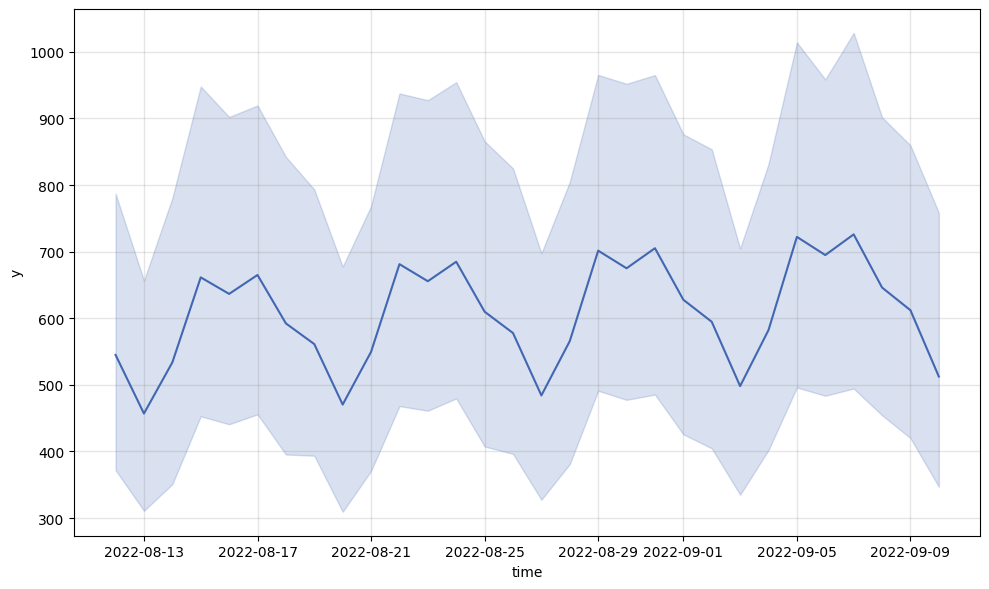

In [259]:
params = ProphetParams(
        seasonality_mode='multiplicative', 
        growth='linear',
        interval_width=0.95,
        daily_seasonality=False, 
        weekly_seasonality=True, 
        yearly_seasonality=False,
        seasonality_prior_scale = 1.0,
        changepoint_prior_scale = 0.01,
        changepoint_range = 0.8)

m = ProphetModel(ts_prophet, params)

m.fit()

fcst = m.predict(steps=30,  freq="D")

fcst['fcst'] = inv_boxcox(fcst['fcst'],lbmd)
fcst['fcst_lower'] = inv_boxcox(fcst['fcst_lower'],lbmd)
fcst['fcst_upper'] = inv_boxcox(fcst['fcst_upper'],lbmd)

m.plot()

Получили предсказание аудитории на 30 дней вперед. Тренд, сезонность были учтены моделью. MAPE модели Prophet несильно отличается от MAPE модели SilverKite 